Import required libraries

In [ ]:
import os
import gc
import csv
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from functools import reduce 
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
import torchvision.transforms as T
from torch.utils.data import Dataset
from google.colab import files, drive
from torch.utils.tensorboard import SummaryWriter

Download dataset

In [ ]:
if not (os.path.isfile("annotations_train.csv") and os.path.isdir("test") and os.path.isdir("train")):
	!gdown --id 14upp5aMYjBwDR57u_H4hMfMKYx5zw8k6
	!unzip dataset.zip > /dev/null
	!rm -r dataset.zip

Downloading...
From: https://drive.google.com/uc?id=14upp5aMYjBwDR57u_H4hMfMKYx5zw8k6
To: /content/dataset.zip
100% 82.9M/82.9M [00:01<00:00, 68.1MB/s]


# Dataset

In [ ]:
class SurveillanceDataset(Dataset):
	def __init__(self, image_subset, directory="train", transform = None, augmentation = None, augm_reduction_factor = 20):
		super(SurveillanceDataset, self).__init__()
		self.augm_reduction_factor = augm_reduction_factor
		self.transform = transform
		annotations_df = pd.read_csv("annotations_train.csv")

		# compute unbalance ratios
		if augmentation is not None:
			self.increment = {}

			# count how many times each attribute value appears
			# for the inferiors get a balance ratio
			for i, label in enumerate(annotations_df.columns[1:]):
				ann = annotations_df[label].value_counts()
				max = np.max(ann.values)
				inc_label = [*range(len(ann.values))]
				for i in range(len(ann.values)):
					inc_label[ann.index[i]-1] = int(max/ann.values[i]) if ann.values[i] != max else 0
				self.increment[label] = inc_label

		# create a dict => img_id(person): attribute labels
		self.image_labels = {} 
		for index, row in annotations_df.iterrows():
			self.image_labels[row[0]] = row[1:len(row)].to_dict() 

		augm_img = 0

		# create a list of tuples with image, person id
		self.image_list = []
		for img_name in image_subset:
			img_id = int(img_name.split("_")[0])
			image = Image.open(os.path.join(directory, img_name))
			self.image_list.append((image, img_id))
	 
	 		# # augmentin data in the dataset randomly
			# if augmentation is not None:
			# 	if np.random.randint(100) < 15:
			# 		self.image_list.append((augmentation(image), img_id))
			# 		augm_img += 1

			# augmentin data in the dataset based by the number of unbalanced labels
			if augmentation is not None:
				tot = np.sum([self.increment[l][v-1] for l, v in self.image_labels[img_id].items()])
				for i in range(tot // self.augm_reduction_factor):
					self.image_list.append((augmentation(image), img_id))
					augm_img += 1
					
		
		# add multi color attribute
		for img_id in self.image_labels:
			self.image_labels[img_id] = self.preprocess_annotation(self.image_labels[img_id])


	def __getitem__(self, idx):
		image = self.image_list[idx][0]
		img_id = self.image_list[idx][1]

		annotation = self.image_labels[img_id]

		if self.transform:
			image = self.transform(image)

		return image, annotation


	def __len__(self):
		return len(self.image_list)

	# multi color attribute
	def preprocess_annotation(self, annotation):
		# [1,2] => [0,1]
		for label in annotation:
			annotation[label] -= 1

		tmp = np.sum([1 for label in annotation.keys() if label.startswith('up') and len(label) > 2 and annotation[label] == 1]) 
		annotation['upmulti'] = 0 if tmp > 0 else 1

		tmp = np.sum([1 for label in annotation.keys() if label.startswith('down') and len(label) > 4 and annotation[label] == 1]) 
		annotation['downmulti'] = 0 if tmp > 0 else 1

		return annotation

In [ ]:
def get_data(batch_size, test_batch_size, data_dir, train_samples_ratio, augm_reduction_factor):
	transform = T.Compose([
		T.ToTensor(),
		T.Normalize(mean=[0.], std=[1.])
	])

	augmentation = T.Compose([
		# T.ColorJitter(brightness=(0.75,1.0), contrast=(0.8,1.0)),
		# T.RandomResizedCrop((128, 64), scale=(0.6, 1.0)),
		T.RandomRotation(degrees=(0,15)),
		T.RandomCrop((96, 48)),
		T.Resize((128, 64)),
		T.RandomHorizontalFlip(p=0.5),
		# T.RandomPerspective(distortion_scale=0.15, p=0.3),
	])

	# create training and validation sets
	file_list = sorted(os.listdir(data_dir))

	# SORTED VERSION
	# training_samples = int(len(file_list) * train_samples_ratio + 1)
	# splitted_list = np.array_split(file_list, [training_samples])

	# create Datasets
	#training_data = SurveillanceDataset(splitted_list[0], data_dir, transform, augmentation, augm_reduction_factor)
	#validation_data = SurveillanceDataset(splitted_list[1], data_dir, transform)

	# RANDOM VERSION
	train_list = []
	valid_list = []

	# group images by id
	file_list_per_id = {}
	for file in file_list:
		img_id = int(file.split("_")[0])
		if file_list_per_id.get(img_id) is None:
			file_list_per_id[img_id] = [file]
		else:
			file_list_per_id[img_id].append(file)	
	 
	shuffled = np.array(list(file_list_per_id.keys()))
	np.random.seed(26)
	np.random.shuffle(shuffled)
	for index, id in enumerate(shuffled):
		train_list.append(file_list_per_id[id]) if index<train_samples_ratio*len(file_list_per_id) else valid_list.append(file_list_per_id[id])

	train_list = np.array(reduce(lambda a, b: a+b, train_list))
	valid_list = np.array(reduce(lambda a, b: a+b, valid_list))

	training_data = SurveillanceDataset(train_list, data_dir, transform, augmentation, augm_reduction_factor)
	validation_data = SurveillanceDataset(valid_list, data_dir, transform)

	# create dataloaders
	train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
	val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)

	return train_loader, val_loader

# Model

In [ ]:
class MyModel(nn.Module):
	
	labels = [
		"age", "backpack", "bag", "handbag", "down", "clothes", "up", "hair", "hat", 
		"gender", "upblack", "upwhite", "upred", "uppurple", "upyellow", "upgray", 
		"upblue", "upgreen", "downblack", "downwhite", "downpink", "downpurple", 
		"downyellow", "downgray", "downblue", "downgreen", "downbrown", "upmulti", "downmulti"]

	def __init__(self, configuration):
		super().__init__()
	
		self.configuration = configuration
		self.model = self.configuration['model'] 
		self.model.fc = nn.Identity() # bypass final layer
		
		# use an extra layer if original network last layer output size is too big
		if self.configuration['use_extra_fc_layer']:
			self.extra_layer = self.configuration['extra_layer']

		# apply last layer differently if age or other attributes
		self.relu = nn.ReLU()
		self.labelsFC = { label: None for label in self.labels }
		self.outputs = self.labelsFC.copy()
		for label in self.labelsFC:
			if label == "age":
				self.labelsFC[label] = nn.Sequential(nn.Linear(self.configuration['last_layer_output_size'], 4), nn.Softmax(dim=1))
			else:
				self.labelsFC[label] = nn.Sequential(nn.Linear(self.configuration['last_layer_output_size'], 1), nn.Sigmoid())

	# ovverride to manage last layer
	def to(self, *args, **kwargs):
		if args[0] == "cuda":
			self.model.cuda(*args)
		else:
			self.model.to(*args, **kwargs)
	 
		self.relu.to(*args, **kwargs)
	
		for label in self.labelsFC:
			self.labelsFC[label].to(*args, **kwargs)
	 
		if self.configuration['use_extra_fc_layer']:
			self.extra_layer.to(*args, **kwargs)
		return self
	
	def forward(self, x):
		x = self.model(x)
		x = self.relu(x)

		if self.configuration['use_extra_fc_layer']:
			x = self.extra_layer(x)

		for label in self.outputs:
			self.outputs[label] = self.labelsFC[label](x)
		return self.outputs, x

# Loss and Accuracy Functions

In [ ]:
class MultiLabelLoss:
	def __init__(self) -> None:
		self.ageLoss = nn.CrossEntropyLoss()
		self.binLoss = nn.BCELoss()

	def __call__(self, out, targets):
		# use cross-entropy for age, binary cross-entropy for other attributes
		loss = self.ageLoss(out["age"], targets["age"])
		for k in out.keys():
			if k != "age":
				loss += self.binLoss(out[k].squeeze(), targets[k].float())
		return loss


class ComputeAccuracies:
	def __init__(self, classes_to_predict) -> None:
		self.cum_acc = { k:0. for k in classes_to_predict }
	
	def __call__(self, out, targets):
		labels = list(out.keys())
		for k in labels:
			if k == "age":
				_, predicted = out[k].max(1)
				self.cum_acc[k] += predicted.eq(targets[k]).sum().item()
			else:
				self.cum_acc[k] += out[k].squeeze().round().int().eq(targets[k]).sum().item()
	
	def get_accuracies(self, tot_samples):
		accuracies = {k:v/tot_samples*100 for k,v in self.cum_acc.items()}
		# compute up_{color} and down_{color} as one average
		up_color_avg = np.average([v for k,v in accuracies.items() if "up" in k and k!="up"]).item()
		down_color_avg = np.average([v for k,v in accuracies.items() if "down" in k and k!="down"]).item()

		# compute average
		remainig_acc = [v for k,v in accuracies.items() if not (("up" in k and k!="up") or ("down" in k and k!="down"))]
		remainig_acc += [up_color_avg, down_color_avg]
		average_acc = np.average(remainig_acc)

		# average_acc = np.average(list(accuracies.values())).item()
		return accuracies, average_acc

# Train and Test Methods

In [ ]:
# computation of 1 train/validation epoch
def step(is_train, net, data_loader, optimizer, cost_function, device="cpu"):
	tot_samples = cumulative_loss = 0.
	accuracy_func = ComputeAccuracies(net.labels)

	if is_train:
		net.train()
	else:
		net.eval()
	with torch.set_grad_enabled(is_train):
		for batch_idx, (inputs, annotations) in enumerate(data_loader):

			# load input to gpu
			inputs = inputs.to(device)
			annotations = { k: v.to(device) for k,v in annotations.items() }
			tot_samples += inputs.shape[0]

			# compute predictions
			outputs, _ = net(inputs)

			# compute loss
			loss = cost_function(outputs, annotations)

			# backpropagation step
			if is_train:
				loss.backward()
				optimizer.step()
				optimizer.zero_grad()
		
			# compute accuracy and cumulative loss
			accuracy_func(outputs, annotations)
			cumulative_loss += loss.item()

	accuracies, avg_acc = accuracy_func.get_accuracies(tot_samples)

	return cumulative_loss/tot_samples, accuracies, avg_acc

In [ ]:
# initialize train and test functions
train = lambda net, data_loader, optimizer, cost_function, device="cpu": step(True, net, data_loader, optimizer, cost_function, device)
test = lambda net, data_loader, cost_function, device="cpu": step(False, net, data_loader, None, cost_function, device)

# Log and util functions

In [ ]:
# create "run" directories to save logs
def exp_folder():
	if not os.path.isdir("runs/"):
		os.mkdir("runs/")
		os.mkdir("runs/exp1")
		return 1
	exp_list = [int(exp[3]) for exp in os.listdir("runs/") if "exp" == exp[:3]]
	return 1 if len(exp_list) == 0 else max(exp_list) + 1


def log_data(writer, train_acc, val_acc, train_loss, val_loss, train_avg_acc, val_avg_acc, epoch):
	writer.add_scalars("Training accuracy", train_acc, epoch)
	writer.add_scalars("Validation accuracy", val_acc, epoch)
	writer.add_scalars("Loss", {"Training":train_loss, "Validation":val_loss}, epoch)
	writer.add_scalars("Accuracy", {"Training":train_avg_acc, "Validation":val_avg_acc}, epoch)


def print_data(train_accuracy, val_accuracy, train_loss, val_loss, train_avg_acc, val_avg_acc, epoch):
	print("▚"*(7*len(train_accuracy.keys())))
	print(f"Epoch: {epoch+1}")
	print(f"train and val losses:\t{train_loss:^10.5f}{val_loss:^10.5f}")
	print(f"train and val avg. acc.:\t{train_avg_acc:^10.2f}{val_avg_acc:^10.2f}")
	line1, line2, line3 = "labels  │", "train   │", "valid.  │"
	for cls in train_accuracy.keys():
		line1 += f"{cls:^10}│"
		line2 += f"{train_accuracy[cls]:^10.2f}│"
		line3 += f"{val_accuracy[cls]:^10.2f}│"
	print(f"{line1}\n{line2}\n{line3}\n")

# Main

In [ ]:
def main(net, batch_size, device, epochs, optimizer, cost_function, data_dir, train_samples_ratio, augm_reduction_factor):
  # Creates a logger for the experiment
  n_exp = str(exp_folder())
  writer = SummaryWriter(log_dir="runs/exp{}".format(n_exp), comment="experiment {}".format(n_exp))

  # Gets DataLoaders
  train_loader, val_loader = get_data(batch_size, batch_size, data_dir, train_samples_ratio, augm_reduction_factor)

  max_val_accuracy = 0
  epochs_without_improvements = 0

  # train the network
  for e in range(epochs):

    # early stopping
    if epochs_without_improvements < 10:

        train_loss, train_accuracy, train_avg_acc = train(net, train_loader, optimizer, cost_function, device)
        val_loss, val_accuracy, val_avg_acc = test(net, val_loader, cost_function, device)

        log_data(writer, train_accuracy, val_accuracy, train_loss, val_loss, train_avg_acc, val_avg_acc, e)

        print_data(train_accuracy, val_accuracy, train_loss, val_loss, train_avg_acc, val_avg_acc, e)

        # save the weights when accuracy increases
        max_val_accuracy = max(val_avg_acc, max_val_accuracy)
        if max_val_accuracy == val_avg_acc:
            print("Best accuracy: {0}".format(max_val_accuracy))
            epochs_without_improvements = 0
            if max_val_accuracy > 88:
                model_name = 'resnet_18_acc_70_30_seed_26_{0}.h5'.format(round(max_val_accuracy, 2))
                torch.save(net, model_name)
                os.system("cp {0} /content/drive/MyDrive/".format(model_name))
        else:
            epochs_without_improvements += 1
            print("Epochs without improvements: {0}".format(epochs_without_improvements))


  # Closes the logger
  writer.close()

# Start training

In [ ]:
# to clean the gpu memory after testing one model
def clean_gpu(model):
  torch.cuda.empty_cache()
  gc.collect()
  model = model.cpu()
  model = None
  del model
  gc.collect()
  torch.cuda.empty_cache()

Define hyperparameters

In [ ]:
epochs = 50
batch_size = 128
device = "cuda" if torch.cuda.is_available() else 'cpu'
data_dir = "train"
train_samples_ratio = 0.7
augm_reduction_factor = 34
lr = 0.0002
weight_decay = 0.001
cost_function = MultiLabelLoss()

Train and test different models

In [ ]:
# store logs and model on google drive to avoid colab crash
save_to_drive = False
if save_to_drive:
    try: 
        drive.mount('/content/drive')
    except:
        save_to_drive = False


def download_to_drive(zip_name, model_name):
    os.system("zip -r /content/{0}.zip /content/runs".format(zip_name))
    os.system("cp {0}.zip /content/drive/MyDrive/".format(zip_name))
    os.system("cp {0} /content/drive/MyDrive/".format(model_name))

Mounted at /content/drive


In [ ]:
configurations = {
    # 'resnet18' : {
    #     'model' : models.resnet18(),
    #     'last_layer_output_size' : 512,
    #     'use_extra_fc_layer' : False,
    #     },
    'resnet18_pretrained' : {
        'model' : models.resnet18(pretrained = True),
        'last_layer_output_size' : 512,
        'use_extra_fc_layer' : False,
        },
    # 'resnext_pretrained' : {
    #     'model' : models.resnext50_32x4d(pretrained = True),
    #     'last_layer_output_size' : 512,
    #     'use_extra_fc_layer' : True,
    #     'extra_layer': nn.Sequential(nn.Linear(2048, 512), nn.Sigmoid())
    #     },
    # 'efficientnet_b0_pretrained' : {
    #     'model' : models.efficientnet_b0(pretrained = True),
    #     'last_layer_output_size' : 512,
    #     'use_extra_fc_layer' : True,
    #     'extra_layer': nn.Sequential(nn.Linear(1000, 512), nn.Sigmoid())
    #     },
}

number_of_trainings = 3
for i in range(number_of_trainings):
    for name, configuration in configurations.items():

        # create the network
        net = MyModel(configuration)
        net = net.to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        print('#######################################')
        print(name)
        print('#######################################')

        # train the network
        main(net, batch_size, device, epochs, optimizer, cost_function, data_dir, train_samples_ratio, augm_reduction_factor)

        # save to drive
        # model_name = 'model_{0}_run_{1}.h5'.format(name, i+1) 
        # zip_name = 'model_{0}_run_{1}'.format(name, i+1)
        # torch.save(net, model_name)
        # download_to_drive(zip_name, model_name)

        clean_gpu(net)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

#######################################
resnet18_pretrained
#######################################
▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚
Epoch: 1
train and val losses:	 0.11885   0.09561  
train and val avg. acc.:	  77.49     85.03   
labels  │   age    │ backpack │   bag    │ handbag  │   down   │ clothes  │    up    │   hair   │   hat    │  gender  │ upblack  │ upwhite  │  upred   │ uppurple │ upyellow │  upgray  │  upblue  │ upgreen  │downblack │downwhite │ downpink │downpurple│downyellow│ downgray │ downblue │downgreen │downbrown │ upmulti  │downmulti │
train   │  54.55   │  70.94   │  67.76   │  65.77   │  83.95   │  88.20   │  88.10   │  74.87   │  94.89   │  80.38   │  86.67   │  73.49   │  91.59   │  86.93   │  76.37   │  87.24   │  74.83   │  90.82   │  80.74   │  89.79   │  83.23   │  82.80   │  94.55   │  62.03

#Download the best model and write output files

In [ ]:
!gdown --id 116ScZ5oGOQVKDFWLC6DI-4q61-FIw8l4

transform = T.Compose([
  T.ToTensor(),
  T.Normalize(mean=[0.], std=[1.])
])

model_name = 'resnet_18_acc_70_30_seed_26_88.63.h5'
model = torch.load(model_name, map_location=torch.device('cpu')) if device == 'cpu' else torch.load(model_name)

Downloading...
From: https://drive.google.com/uc?id=116ScZ5oGOQVKDFWLC6DI-4q61-FIw8l4
To: /content/resnet_18_acc_70_30_seed_26_88.63.h5
100% 44.9M/44.9M [00:00<00:00, 54.4MB/s]


In [ ]:
class SurveillanceTestDataset(Dataset):
  def __init__(self, directory="test", transform = None):
    super(SurveillanceTestDataset, self).__init__()
    self.transform = transform

  # create a list of tuples with image, person id
    self.image_list = []
    for index, img_name in enumerate(os.listdir(directory)):
      if index < 65:
        image = Image.open(os.path.join(directory, img_name))
        self.image_list.append((image, img_name))

    print("Total size: {0}".format(len(self.image_list)))


  def __getitem__(self, idx):
    image = self.image_list[idx][0]
    img_name = self.image_list[idx][1]

    if self.transform:
      image = self.transform(image)

    return image, img_name


  def __len__(self):
    return len(self.image_list)

In [ ]:
def get_test_data(batch_size):
	transform = T.Compose([
		T.ToTensor(),
		T.Normalize(mean=[0.], std=[1.])
	])

	test_data = SurveillanceTestDataset(transform = transform)

	test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

	return test_loader

In [ ]:
def write_classification_csv(data_dir):
  predictions_dict = {}
  # for each image in the directory
  for img_name in tqdm(sorted(os.listdir(data_dir))):
    # get the predicted output
    img = Image.open(os.path.join(data_dir, img_name))
    output, _ = model(torch.reshape(transform(img).cuda(), (1, 3, 128, 64))) if device == 'cuda' else model(torch.reshape(transform(img), (1, 3, 128, 64)))
    # prepare a dict with the predictions
    predictions_dict[img_name] = {}
    for label, prediction in output.items():
      value = 1 + int(torch.argmax(prediction) if label == 'age' else prediction>0.5) 
      predictions_dict[img_name][label] = value

  header = ["id","age","backpack","bag","handbag","clothes","down","up","hair","hat","gender",
"upblack","upwhite","upred","uppurple","upyellow","upgray","upblue","upgreen", "upmulti",
"downblack","downwhite","downpink","downpurple","downyellow","downgray","downblue","downgreen","downbrown", "downmulti"]

  # prepare csv file
  f = open('classification_test.csv', 'w')
  writer = csv.writer(f)
  writer.writerow(header)
  
  # for each image save the id (image name) and predictions
  for img_name, prediction in predictions_dict.items():
    data = [img_name]
    for label in header:
      if label is not "id":
        data.append(prediction[label])

    # write the data
    writer.writerow(data)

  f.close()
  
  files.download("classification_test.csv")

In [ ]:
write_classification_csv('test')

100%|██████████| 19679/19679 [02:36<00:00, 125.38it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/011859.jpg


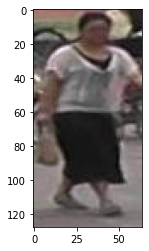

age : 2
backpack : 1
bag : 1
handbag : 1
down : 2
clothes : 2
up : 2
hair : 1
hat : 1
gender : 1
upblack : 1
upwhite : 2
upred : 1
uppurple : 1
upyellow : 1
upgray : 1
upblue : 1
upgreen : 1
downblack : 2
downwhite : 1
downpink : 1
downpurple : 1
downyellow : 1
downgray : 1
downblue : 1
downgreen : 1
downbrown : 1
upmulti : 1
downmulti : 1


In [ ]:
annotations_df = pd.read_csv("annotations_train.csv")

test_dir = 'test'

image_index = 26

if test_dir == 'train':
  person_id = os.listdir(test_dir)[image_index].split('_')[0]
  attributes_gt = annotations_df.loc[(annotations_df['id'] == int(person_id)).idxmax()]

  tmp = np.sum([1 for label in attributes_gt.keys() if label.startswith('up') and len(label) > 2 and attributes_gt[label] == 1]) 
  attributes_gt['upmulti'] = 1 if tmp > 0 else 2

  tmp = np.sum([1 for label in attributes_gt.keys() if label.startswith('down') and len(label) > 4 and attributes_gt[label] == 1]) 
  attributes_gt['downmulti'] = 1 if tmp > 0 else 2

image_path = os.path.join(test_dir, os.listdir(test_dir)[image_index])
print(image_path)
img = Image.open(image_path)

plt.figure()
plt.imshow(img) 
plt.show()  # display it

output, _ = model(torch.reshape(transform(img).cuda(), (1, 3, 128, 64))) if device == 'cuda' else model(torch.reshape(transform(img), (1, 3, 128, 64)))
tot_correct = 0
for label, prediction in output.items():
  value = 1 + (torch.argmax(prediction) if label == 'age' else int(prediction>0.5)) 

  if test_dir == 'train':
    correct = 'Correct' if value == attributes_gt[label] else f'WRONG ({attributes_gt[label]})'
    tot_correct += 1 if value == attributes_gt[label] else 0
  print(( f'{label} : {value} \t\t\t{correct}' ) if test_dir == 'train' else ( f'{label} : {value}') ) 


if test_dir == 'train':
  print(f'Accuracy: {tot_correct/(len(attributes_gt)-1)}')
